# Can I undetand what a Normal mixture model is and how to use it?


In [1]:
%matplotlib inline
#%matplotlib notebook
%load_ext version_information
%load_ext autoreload


In [51]:
import datetime
import os
import sys
import warnings

warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacepy.datamodel as dm
import spacepy.toolbox as tb
import tqdm
import pymc3 as mc3
import seaborn as sns
sns.set()

%version_information matplotlib, numpy, pandas

Software versions
Python 3.7.5 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.9.0
OS Darwin 18.7.0 x86_64 i386 64bit
matplotlib 3.1.1
numpy 1.17.3
pandas 0.25.3
Fri Nov 08 16:49:27 2019 CST

In [76]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['savefig.dpi'] = plt.rcParams['figure.dpi'] # 72
%config InlineBackend.figure_format = 'retina'

In [81]:
# Lets make to Normal distributions and add them together
locs = np.asarray([3,10])
sds = np.asarray([2,2])
D1 = np.random.normal(locs[0], sds[0], size=100)
D2 = np.random.normal(locs[1], sds[1], size=80)

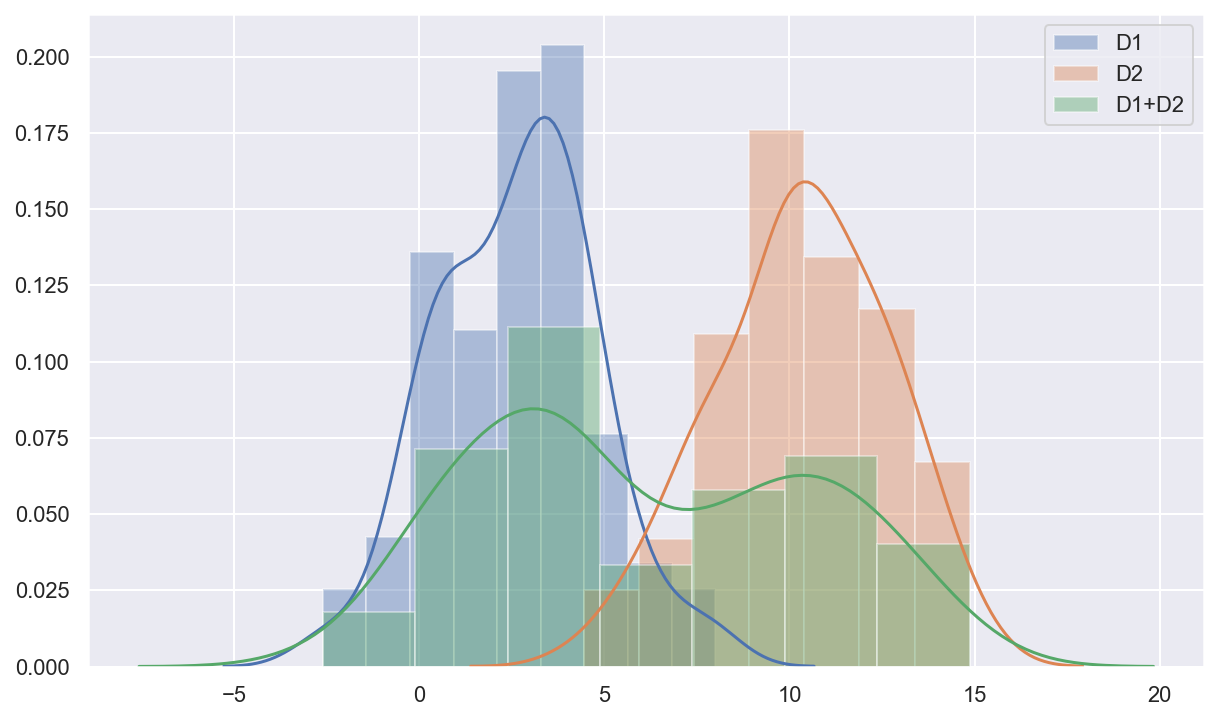

In [82]:
# bins = np.linspace(-24,24, 100)
sns.distplot(D1, kde=True, label='D1')
sns.distplot(D2, kde=True, label='D2')

# plt.hist(D1, bins=bins, histtype='step', lw=3, label='D1')
# plt.hist(D2, bins=bins, histtype='step', lw=3, label='D2')
D = np.append(D1,D2)
sns.distplot(D, kde=True, label='D1+D2')

plt.legend()

In [113]:
D.shape

(180,)

In [114]:
SEED = 20161210
with mc3.Model() as model:
    w = mc3.Dirichlet('w', np.ones_like(locs))

    mu = mc3.Uniform('mu', -10., 20., shape=locs.size)
    sd = mc3.Gamma('sd', 1., 1., shape=locs.size)

    x_obs = mc3.NormalMixture('x_obs', w, mu, sd=sd, observed=D)
    trace = mc3.sample(1000, tune=4000, random_seed=SEED)[100:]
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu, w]
Sampling 2 chains: 100%|██████████| 10000/10000 [00:10<00:00, 925.65draws/s]


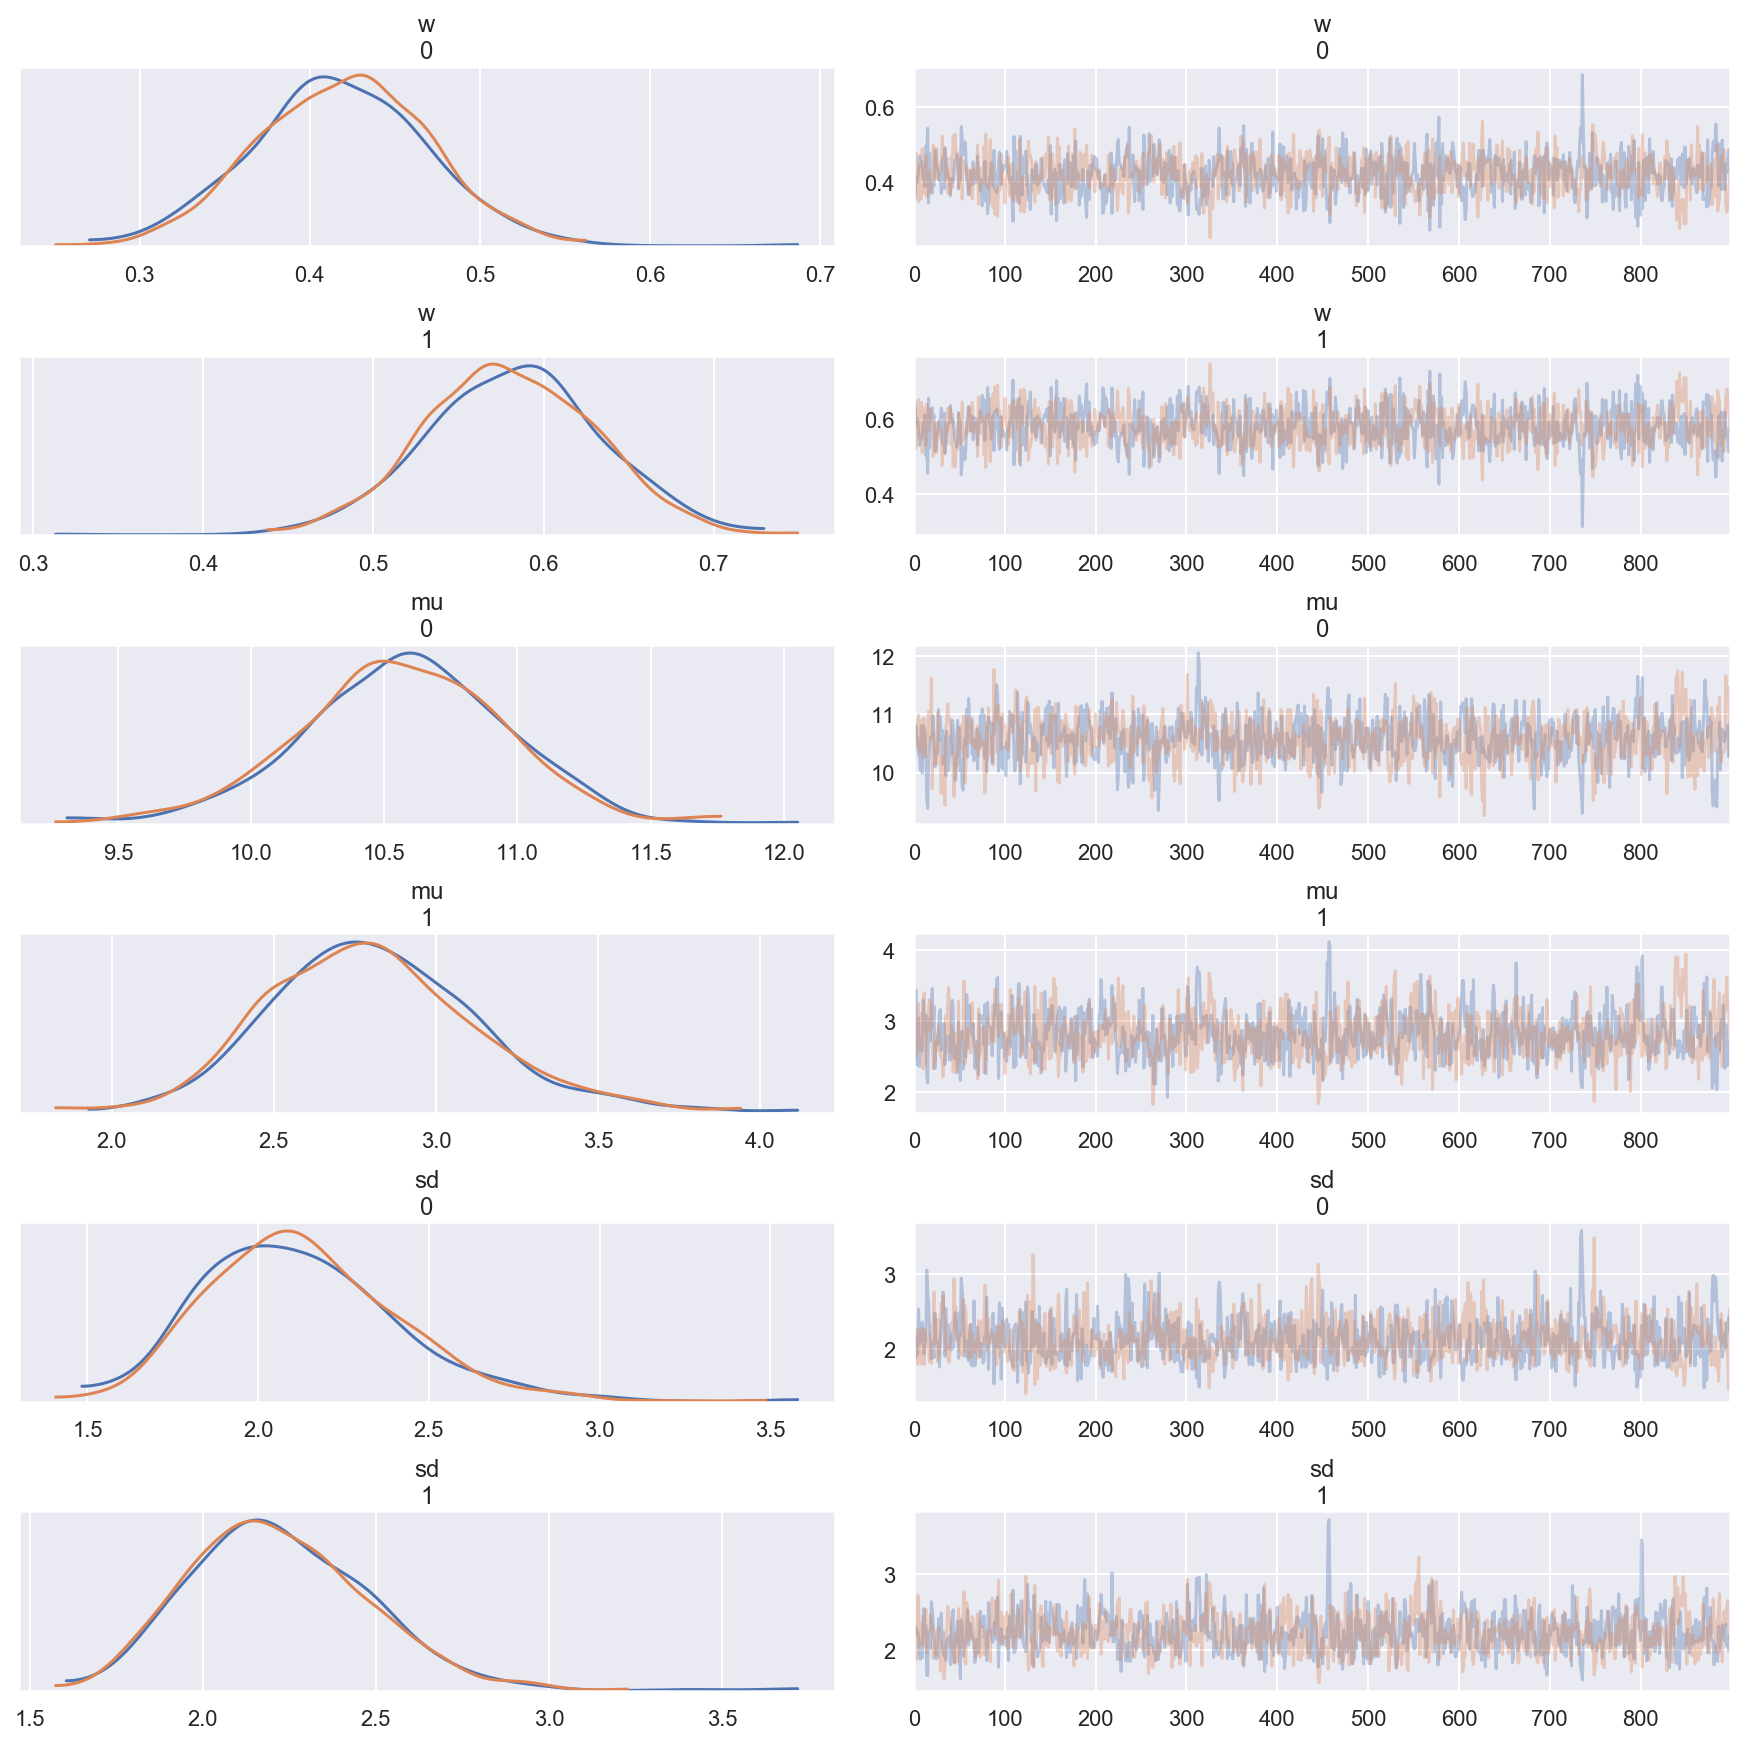

In [115]:
mc3.traceplot(trace, combined=False);


In [116]:
mc3.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w__0,0.418748,0.049813,0.001729,0.322656,0.515661,690.123426,0.999978
w__1,0.581252,0.049813,0.001729,0.484339,0.677344,690.123426,0.999978
mu__0,10.570824,0.379134,0.012052,9.827874,11.287996,797.915218,1.000247
mu__1,2.808082,0.321692,0.011146,2.214258,3.486714,660.365005,1.000139
sd__0,2.128989,0.280798,0.009118,1.576299,2.647154,859.876193,0.999844
sd__1,2.223601,0.256571,0.008812,1.753544,2.699334,752.050276,1.000200


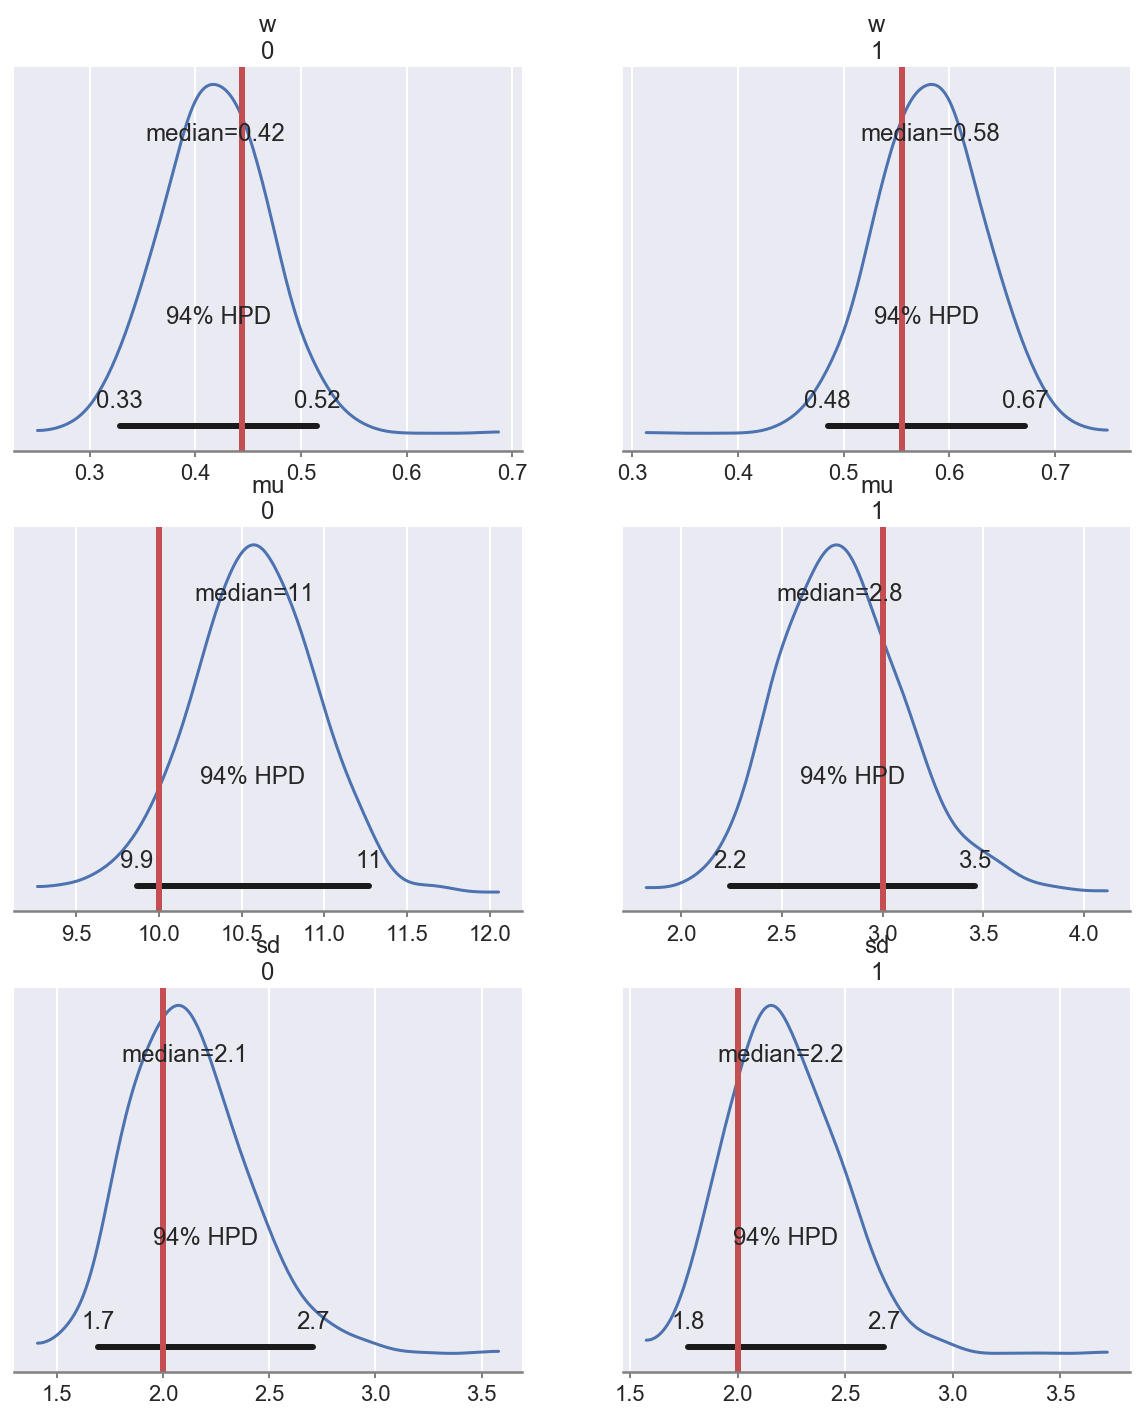

In [117]:
fig, ax = plt.subplots(3, 2, figsize=(10,12))
axs = mc3.plot_posterior(trace, point_estimate='median', ax=ax)
ax = ax.flatten()
ax[0].axvline(8000/(10000+8000), c='r', lw=3)
ax[1].axvline(1-8000/(10000+8000), c='r', lw=3)

ax[2].axvline(10, c='r', lw=3)
ax[3].axvline(3, c='r', lw=3)

ax[4].axvline(2, c='r', lw=3)
ax[5].axvline(2, c='r', lw=3)


In [118]:
ppc = mc3.sample_posterior_predictive(trace, samples=205, model=model)


100%|██████████| 205/205 [00:01<00:00, 147.77it/s]


In [119]:
hist, bins = np.histogram(ppc['x_obs'], bins='doane', normed=True)
hist2 = []
for i in tqdm.tqdm_notebook(range(ppc['x_obs'].shape[0])):
    h, _ = np.histogram(ppc['x_obs'][i], bins=bins, normed=True)
    hist2.append(h)

In [120]:
hist2 = np.asarray(hist2)
hist2.shape

(205, 21)

In [121]:
perc = np.percentile(hist2, [2.5, 97.5, 50], axis=0)
perc.shape

(3, 21)

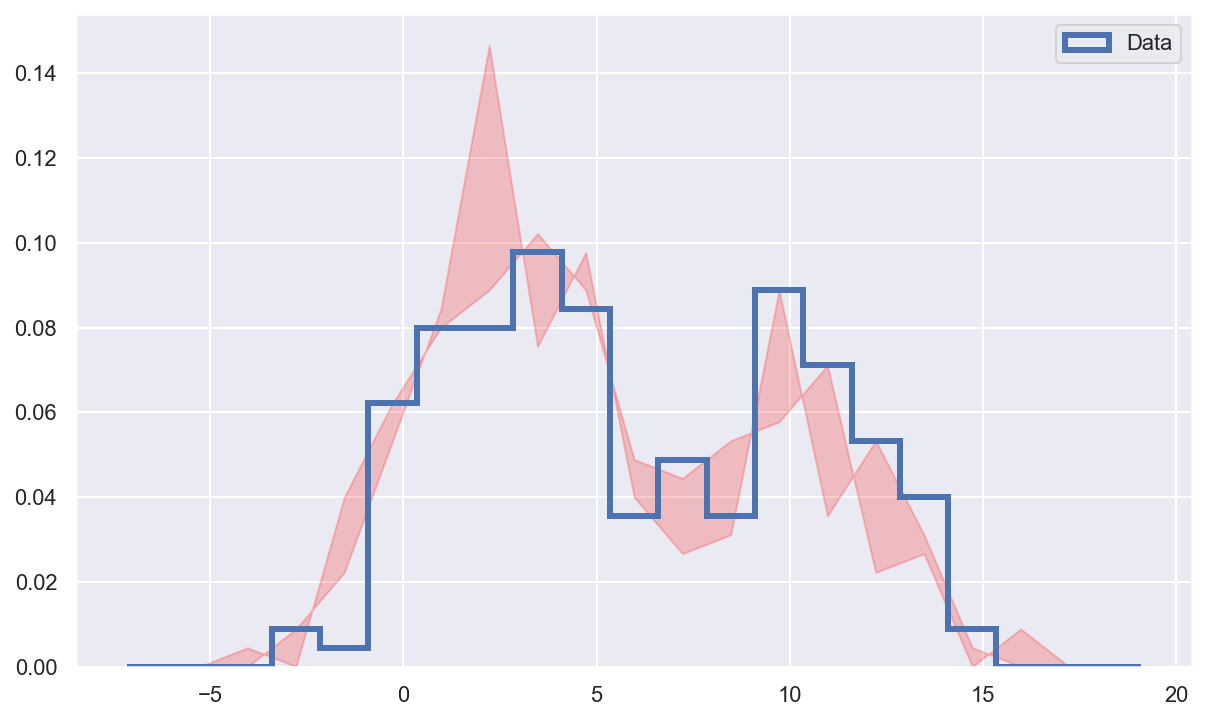

In [123]:
# plt.plot(tb.bin_edges_to_center(bins), hist2[2,:], lw=4, label='MCMC')
plt.fill_between(tb.bin_edges_to_center(bins), hist2[0,:], hist2[1,:], color='red', alpha=0.2)
plt.hist(D, bins=bins, histtype='step', lw=3, normed=True, label='Data');
plt.legend();

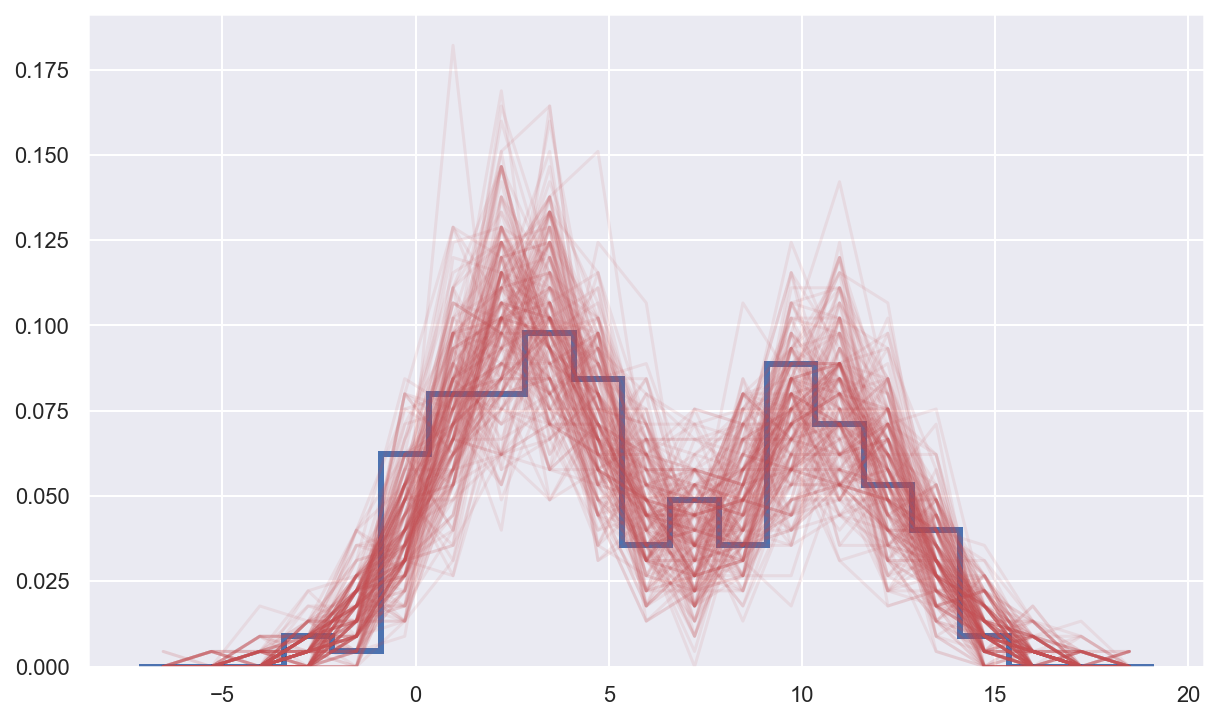

In [130]:
plt.plot(tb.bin_edges_to_center(bins), hist2.T, c='r', alpha=0.1);
plt.hist(D, bins=bins, histtype='step', lw=3, normed=True, label='Data');


# What happens if we try and fit 1 more than we had?


In [93]:
np.ones_like(locs), locs.size

(array([1, 1]), 2)

In [94]:
SEED = 20161210
with mc3.Model() as model:
    w = mc3.Dirichlet('w', np.ones(3))

    mu = mc3.Uniform('mu', -10., 20., shape=3)
    sd = mc3.Gamma('sd', 1., 1., shape=3)

    x_obs = mc3.NormalMixture('x_obs', w, mu, sd=sd, observed=D)
    trace = mc3.sample(1000, tune=4000, random_seed=SEED)[100:]
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu, w]
Sampling 2 chains: 100%|██████████| 10000/10000 [00:45<00:00, 220.68draws/s]
The acceptance probability does not match the target. It is 0.7213512362490077, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


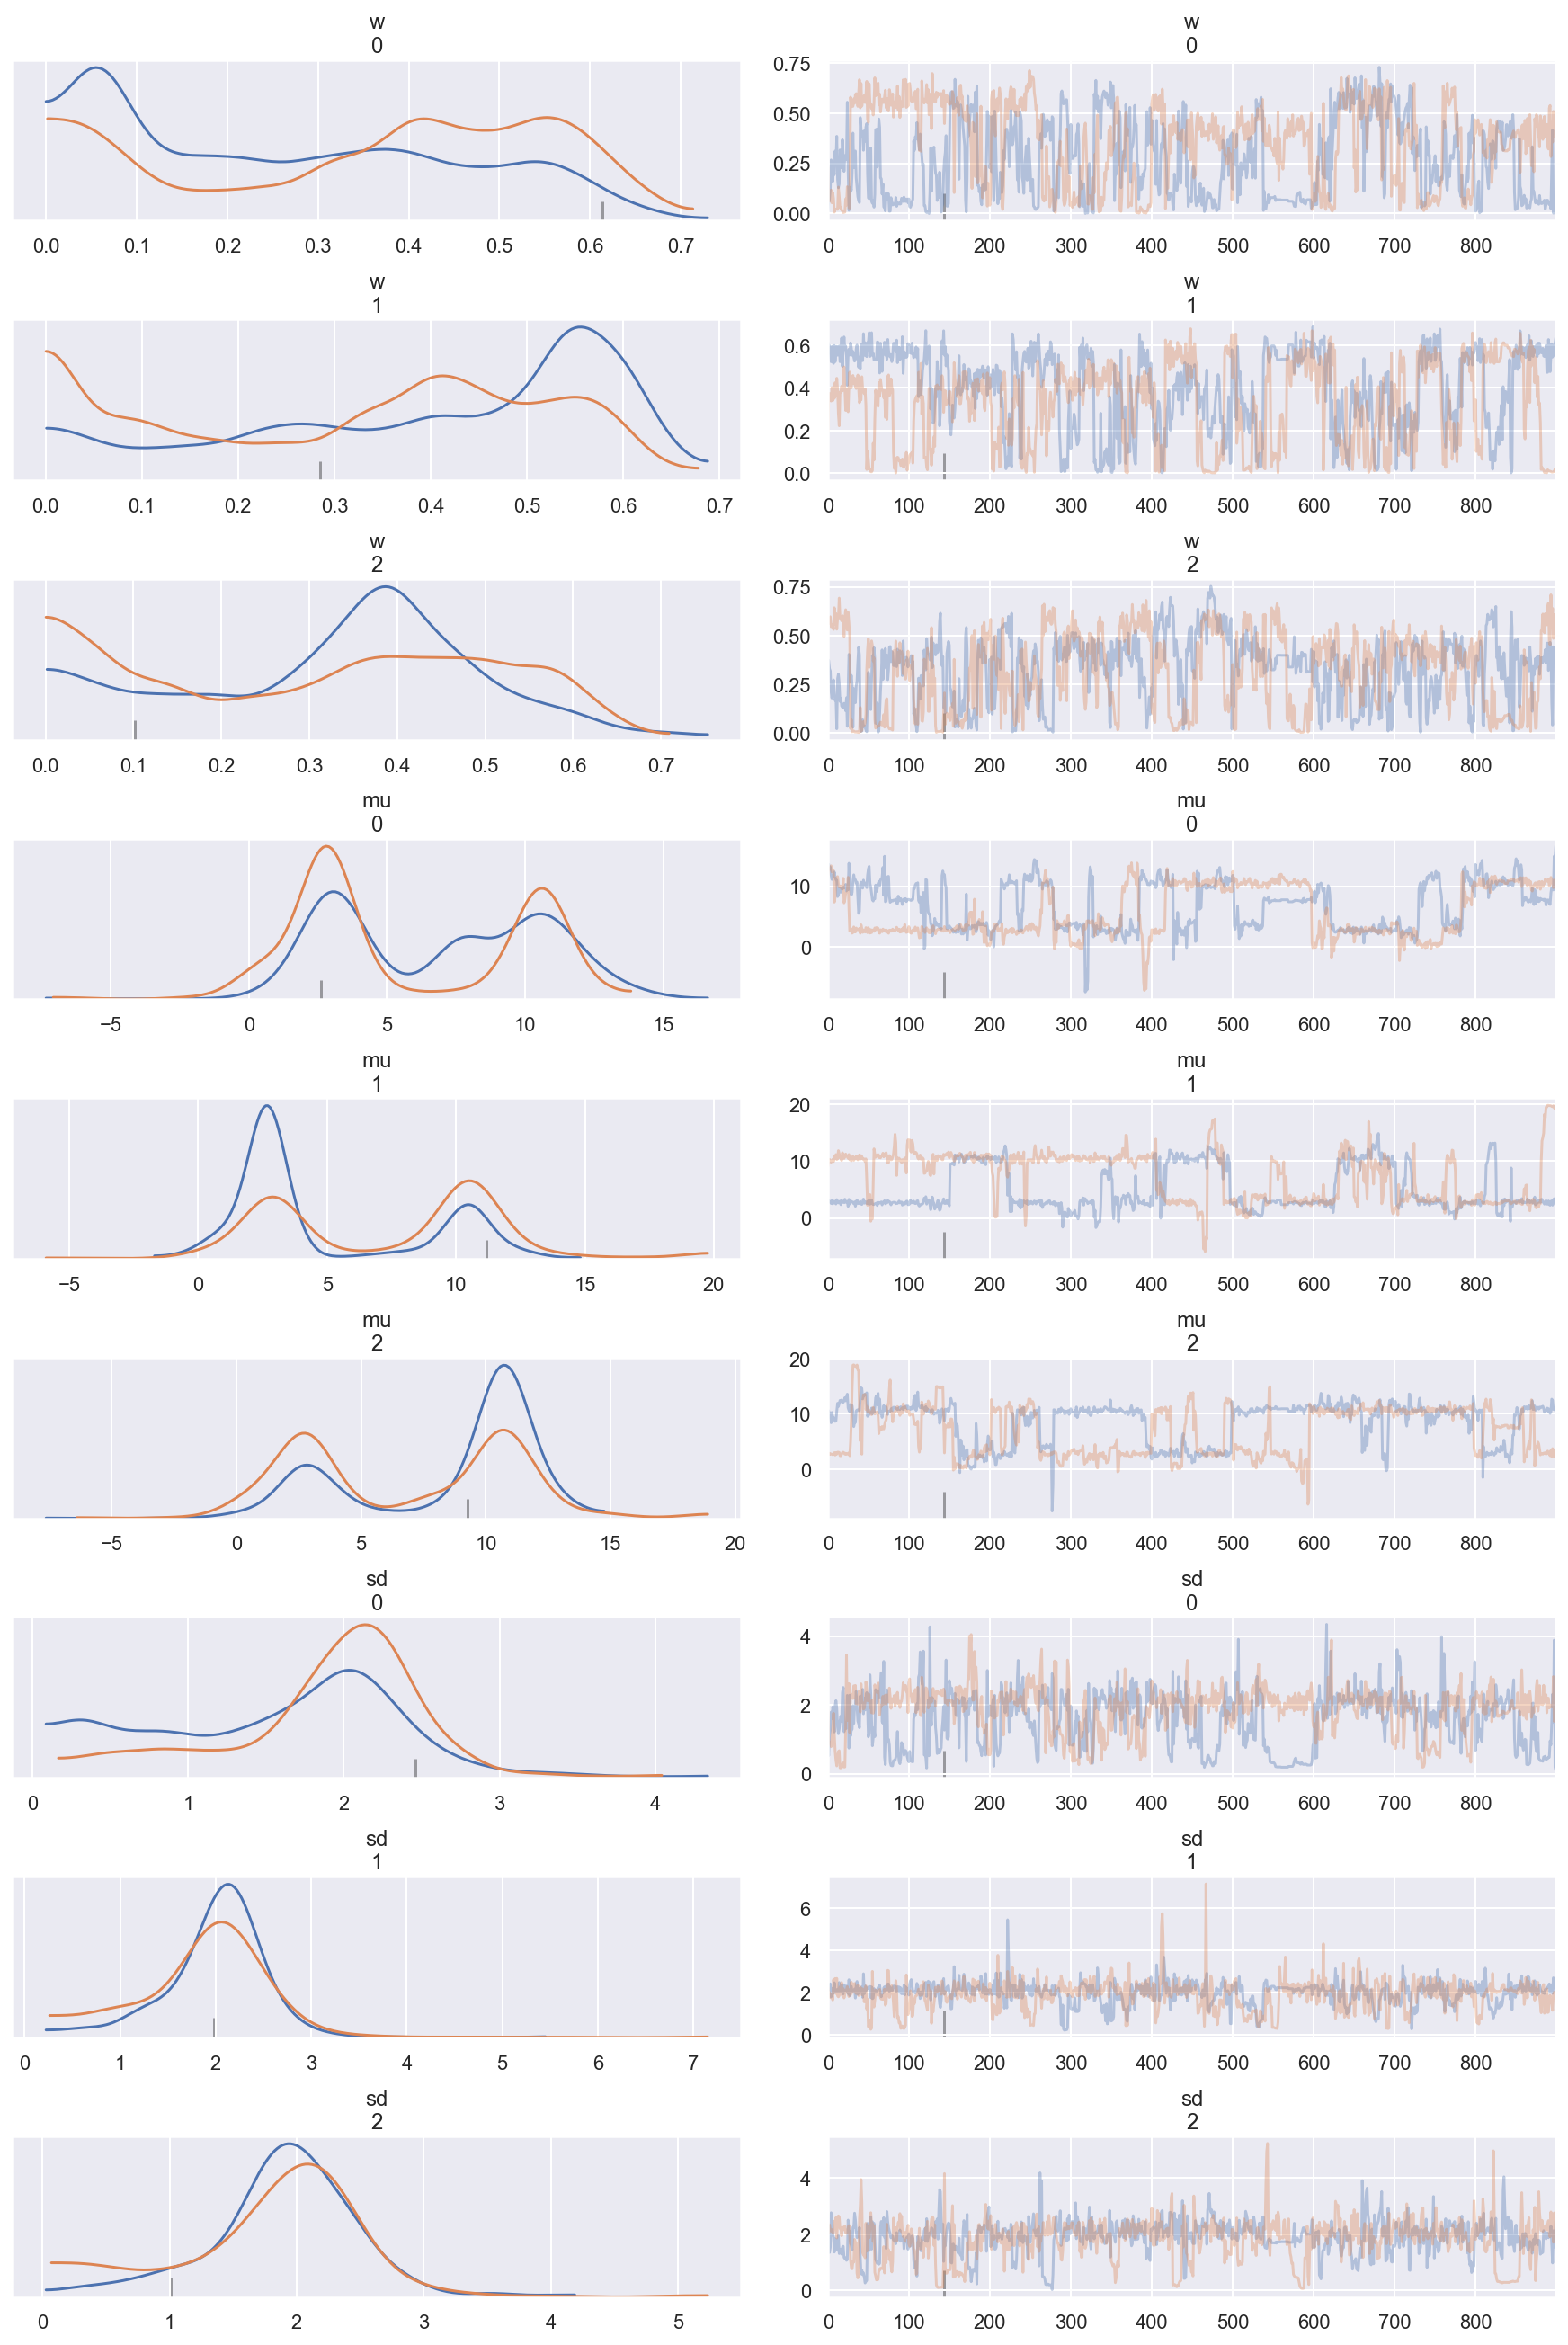

In [95]:
mc3.traceplot(trace, combined=False);


In [96]:
mc3.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w__0,0.312153,0.200202,0.015272,0.001565,0.609614,42.083284,1.056298
w__1,0.363992,0.192752,0.014489,0.001312,0.610719,69.848318,1.041630
w__2,0.323855,0.181285,0.012720,0.001502,0.596365,119.124245,1.001337
mu__0,6.280732,4.023692,0.346288,0.300453,12.667621,30.271210,1.021969
mu__1,6.119546,4.284265,0.383118,-0.177347,12.356174,19.325555,1.088465
mu__2,7.666325,4.152672,0.352901,0.176533,12.730619,31.077220,1.046554
sd__0,1.730737,0.734515,0.050198,0.185583,2.707843,66.163461,1.045203
sd__1,1.952408,0.595265,0.032802,0.434038,2.803932,210.931557,1.006848
sd__2,1.852558,0.658708,0.036656,0.265970,2.873346,198.383152,1.004821


In [97]:
ppc = mc3.sample_posterior_predictive(trace, samples=205, model=model)

100%|██████████| 205/205 [00:01<00:00, 201.07it/s]


In [110]:
hist, bins = np.histogram(ppc['x_obs'], bins='doane', normed=True)
hist2 = []
for i in tqdm.tqdm_notebook(range(ppc['x_obs'].shape[0])):
    h, _ = np.histogram(ppc['x_obs'][i], bins=bins, normed=True)
    hist2.append(h)
hist2 = np.asarray(hist2)
perc = np.percentile(hist2, [2.5, 97.5, 50], axis=0)


In [111]:
hist2.shape

(205, 21)

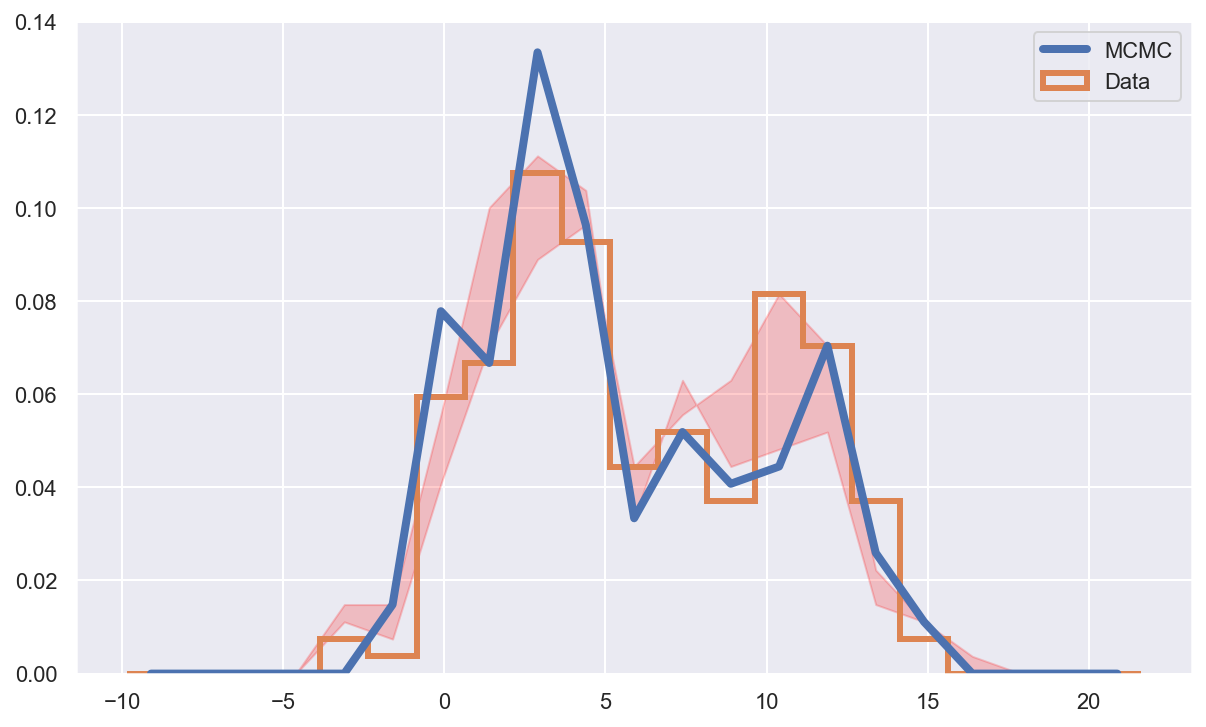

In [112]:
plt.plot(tb.bin_edges_to_center(bins), hist2[2,:], lw=4, label='MCMC')
plt.fill_between(tb.bin_edges_to_center(bins), hist2[0,:], hist2[1,:], color='red', alpha=0.2)
plt.hist(D, bins=bins, histtype='step', lw=3, normed=True, label='Data');
plt.legend();

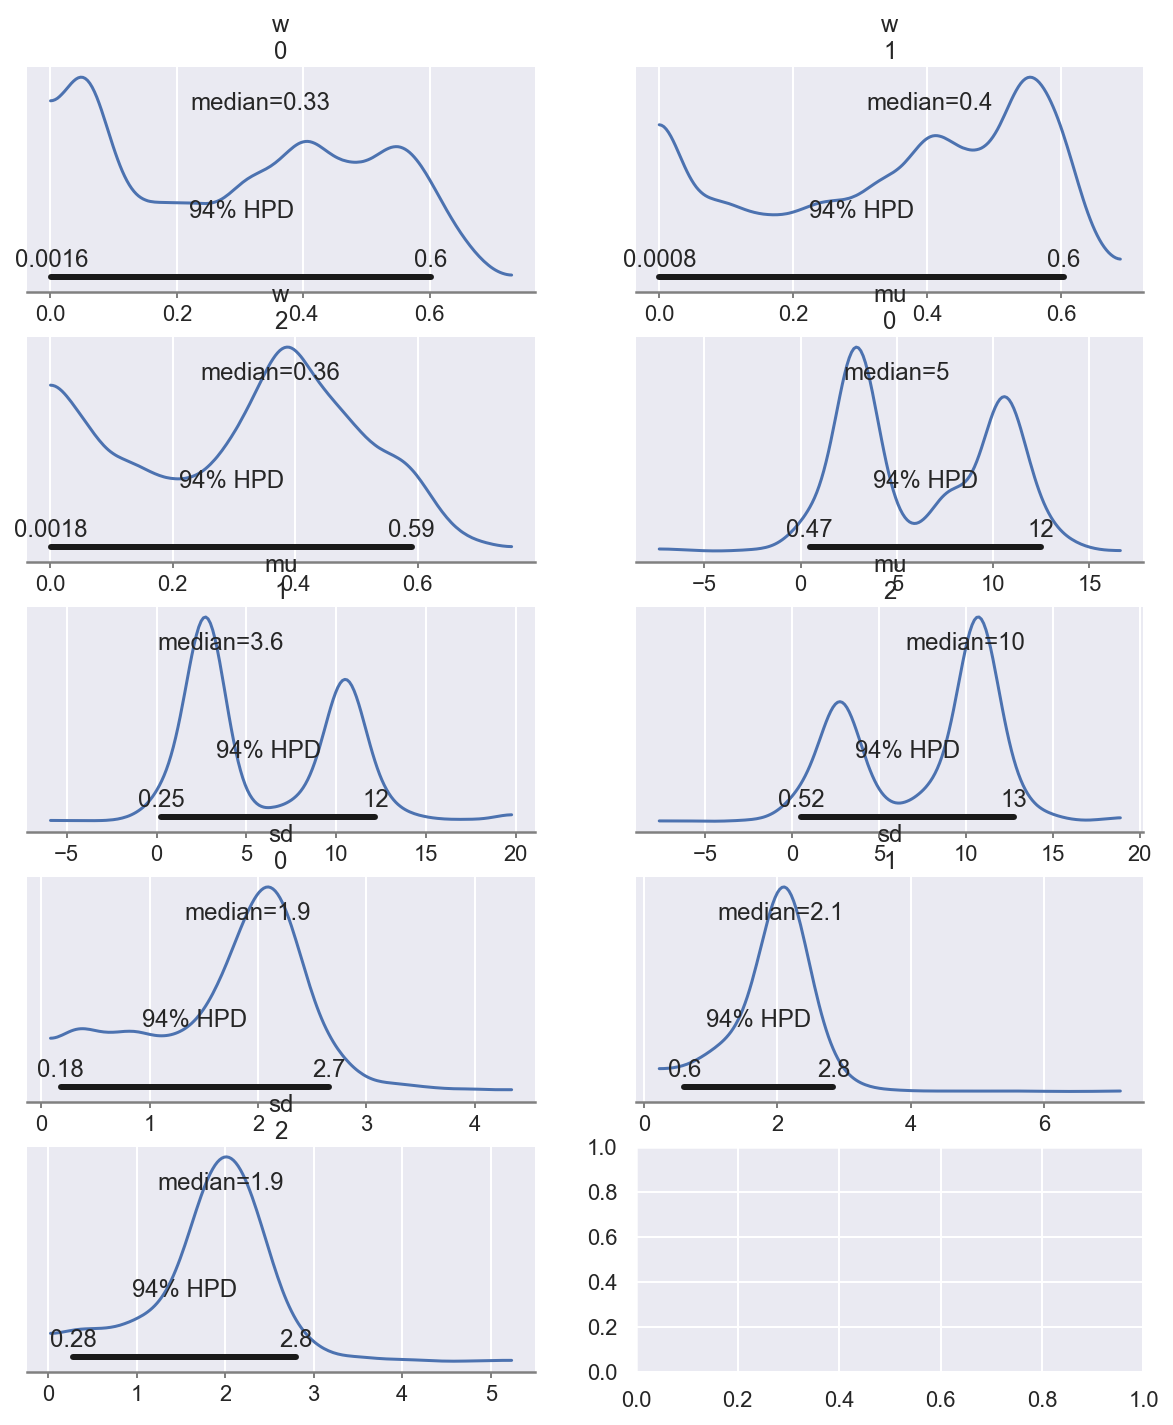

In [100]:
fig, ax = plt.subplots(5, 2, figsize=(10,12))
axs = mc3.plot_posterior(trace, point_estimate='median', ax=ax)

# how about way more?

In [101]:
SEED = 20161210
with mc3.Model() as model:
    w = mc3.Dirichlet('w', np.ones(10))

    mu = mc3.Uniform('mu', -10., 20., shape=10)
    sd = mc3.Gamma('sd', 1., 1., shape=10)

    x_obs = mc3.NormalMixture('x_obs', w, mu, sd=sd, observed=D)
    trace = mc3.sample(1000, tune=4000, random_seed=SEED)[100:]
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu, w]
Sampling 2 chains: 100%|██████████| 10000/10000 [08:22<00:00, 19.88draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7061952590064255, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6571826146114126, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [102]:
ppc = mc3.sample_posterior_predictive(trace, samples=205, model=model)

100%|██████████| 205/205 [00:01<00:00, 162.88it/s]


In [107]:
ppc['x_obs'].shape

(205, 180)

In [108]:
hist, bins = np.histogram(ppc['x_obs'], bins='doane', normed=True)
hist2 = []
for i in tqdm.tqdm_notebook(range(ppc['x_obs'].shape[0])):
    h, _ = np.histogram(ppc['x_obs'][i], bins=bins, normed=True)
    hist2.append(h)
hist2 = np.asarray(hist2)
perc = np.percentile(hist2, [2.5, 97.5, 50], axis=0)


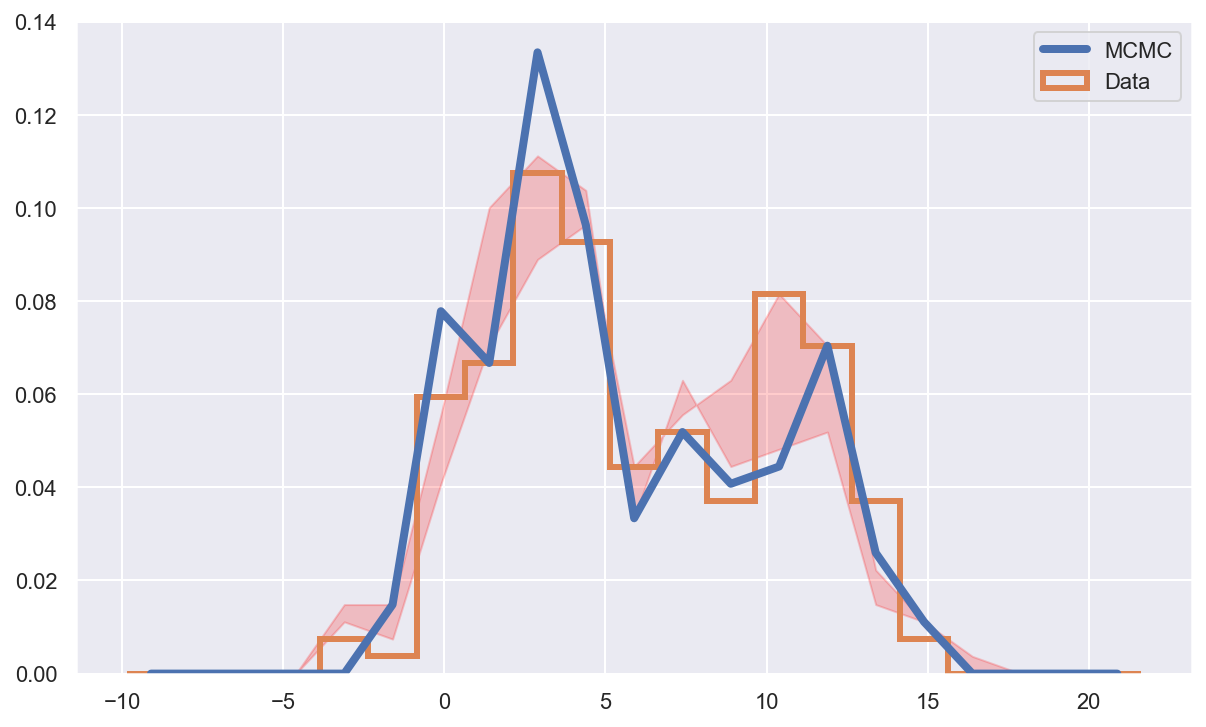

In [109]:
plt.plot(tb.bin_edges_to_center(bins), hist2[2,:], lw=4, label='MCMC')
plt.fill_between(tb.bin_edges_to_center(bins), hist2[0,:], hist2[1,:], color='red', alpha=0.2)
plt.hist(D, bins=bins, histtype='step', lw=3, normed=True, label='Data');
plt.legend();

In [106]:
mc3.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w__0,0.103413,0.092281,0.004059,1.230685e-04,0.283837,417.655581,1.003953
w__1,0.112620,0.100001,0.005543,3.837580e-04,0.333868,181.795993,1.001259
w__2,0.096115,0.085142,0.003713,2.631887e-06,0.259823,338.618326,1.000245
w__3,0.102036,0.089301,0.003314,1.783121e-04,0.290462,626.489415,0.999445
w__4,0.105493,0.091619,0.004363,8.718963e-05,0.289211,212.498151,1.011922
w__5,0.091962,0.090634,0.004842,1.484206e-04,0.281233,314.275621,0.999489
w__6,0.091259,0.085936,0.004334,1.467980e-04,0.259275,306.767458,0.999471
w__7,0.097675,0.087628,0.003907,2.979057e-05,0.281999,367.613137,0.999445
w__8,0.099904,0.093334,0.004155,4.213182e-07,0.306513,312.554912,0.999758
w__9,0.099523,0.088337,0.003975,2.293775e-06,0.279621,463.061962,0.999672


In [ ]:
with mc3.Model() as model:
    w = mc3.Dirichlet('w', np.ones_like(locs))

    mu1 = mc3.Uniform('mu1', -10., 20.)
    mu2 = mc3.Uniform('mu2', mu1, 20.)
    sd = mc3.Gamma('sd', 1., 1., shape=locs.size)

    x_obs = mc3.NormalMixture('x_obs', w, [mu1, mu2], sd=sd, observed=D)
    start = mc3.find_MAP()
    trace = mc3.sample(5000, n_init=10000, tune=1000, random_seed=SEED, start=start)[1000:]
    
    
    

In [ ]:
mc3.traceplot(trace, combined=True);
mc3.summary(trace)

In [ ]:
ppc = mc3.sample_ppc(trace, samples=5000, model=model)
hist, bins = np.histogram(ppc['x_obs'], bins='doane', normed=True)
plt.plot(tb.bin_edges_to_center(bins), hist, lw=4, label='MCMC')
plt.hist(D, bins=bins, histtype='step', lw=3, normed=True, label='Data');
plt.legend()

## And do the same with mixture

In [ ]:
D.shape

In [ ]:
with mc3.Model() as model:
    w = mc3.Dirichlet('w', np.ones_like(locs))

    mu = mc3.Uniform('mu', -10., 20., shape=locs.size)
    sd = mc3.Gamma('sd', 1., 1., shape=locs.size)
    
    x_obs = mc3.Mixture('x_obs', w=w, comp_dists=mc3.Normal.dist(mu=mu, sd=sd), observed=D)

    start = mc3.find_MAP()
    trace = mc3.sample(5000, n_init=10000, tune=1000, random_seed=SEED, start=start)[1000:]
    
    

In [ ]:
def test_mixture_list_of_poissons(self):
    with Model() as model:
        w = Dirichlet('w', np.ones_like(self.pois_w))
 
        mu = Gamma('mu', 1., 1., shape=self.pois_w.size)
 
        x_obs = Mixture('x_obs', w,
                        [Poisson.dist(mu[0]), Poisson.dist(mu[1])],
                        observed=self.pois_x)
 
        step = Metropolis()
        trace = sample(5000, step, random_seed=self.random_seed, progressbar=False)
 
    assert_allclose(np.sort(trace['w'].mean(axis=0)),
                    np.sort(self.pois_w),
                    rtol=0.1, atol=0.1)
    assert_allclose(np.sort(trace['mu'].mean(axis=0)),
                    np.sort(self.pois_mu),
                    rtol=0.1, atol=0.1)

    
    
    
    
    

In [ ]:
ppc = mc3.sample_ppc(trace, samples=5000, model=model)
hist, bins = np.histogram(ppc['x_obs'], bins='doane', normed=True)
plt.plot(tb.bin_edges_to_center(bins), hist, lw=4, label='MCMC')
plt.hist(D, bins=bins, histtype='step', lw=3, normed=True, label='Data');
plt.legend()

In [ ]:
mc3.traceplot(trace, combined=True);
mc3.summary(trace)

In [ ]:
with mc3.Model() as model:
    w = mc3.Dirichlet('w', np.ones_like(locs))

    mu1 = mc3.Uniform('mu1', -10., 20.,)
    mu2 = mc3.Uniform('mu2', mu1, 20., )
    
    sd = mc3.Gamma('sd', 1., 1., shape=locs.size)
    
    x_obs = mc3.Mixture('x_obs', w=w, comp_dists=mc3.Normal.dist(mu=[mu1,mu2], sd=sd, shape=locs.size), 
                        observed=D)

    start = mc3.find_MAP()
    trace = mc3.sample(5000, n_init=10000, tune=1000, random_seed=SEED, start=start)[1000:]
    
    

In [ ]:
mc3.traceplot(trace, combined=True);
mc3.summary(trace)

In [ ]:
ppc = mc3.sample_ppc(trace, samples=5000, model=model)
hist, bins = np.histogram(ppc['x_obs'], bins='doane', normed=True)
plt.plot(tb.bin_edges_to_center(bins), hist, lw=4, label='MCMC')
plt.hist(D, bins=bins, histtype='step', lw=3, normed=True, label='Data');
plt.legend()